# Homework 03: Learning Curves and Training Workflow

## Due: Midnight on September 21 (with 2-hour grace period)

**Points:** 85

In this assignment, you will learn how to design, train, and evaluate neural networks by systematically exploring key design choices. Your focus will be on developing an effective **training workflow** — using learning curves and validation metrics to guide your decisions.

We'll use the **Forest Cover Type (Covertype) dataset,** which has ~581k tabular records with 54 cartographic/topographic features (elevation, aspect, slope, soil and wilderness indicators) used to predict one of seven tree cover types in Colorado’s Roosevelt National Forest. It’s a large, mildly imbalanced multi-class benchmark commonly used to compare classical ML and deep learning on tabular data.

We will start with a **baseline model** (two hidden layers of sizes 64 and 32), and gradually introduce and tune different hyperparameters. Each of the first five problems considers  different hyperparameter choices, and the last problem is your chance to use what you have learned to design your best model:

1. **Activation function** – Compare ReLU, sigmoid, and tanh to see which provides the best accuracy.
2. **Learning rate** – Explore a range of learning rates and identify which balances convergence speed and stability.
3. **Dropout** – Investigate how different dropout rates reduce overfitting and where they are most effective.
4. **L2 regularization** – Experiment with weight penalties to encourage simpler models and avoid memorization.
5. **Dropout + L2** – Combine both regularization techniques and study their interaction.
6. **Best model design** – Use all your insights to build and train your strongest model, with the option to try **learning rate scheduling** for further improvement.

Throughout, you will use **early stopping** to select the model at the epoch of **minimum validation loss**, and you will report the **validation accuracy** of that selected model as the primary measure of performance.

By the end of this homework, you will not only understand how different hyperparameters affect training and generalization, but also gain hands-on practice in building a disciplined workflow for model development.

There are 10 graded problems, worth 8 points each, with 5 points for free if you complete the homework. 

In [1]:
# Useful imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from tensorflow.keras.datasets import fashion_mnist

# utility code

random_seed = 42

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


2025-09-21 01:53:03.843930: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-21 01:53:03.897359: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-21 01:53:05.951980: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
# Utility function to plot learning curves and keep track of all results

# Call `print_results()` to see listing of all results logged so far


def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,{min_val_epoch + 1})

results = {}

**The plotting function will record the validation accuracy for each experiment, using the plot title as key. The next function will print these out (see the last cell in the notebook).**


In order to see all results, you must give a different plot title to each experiment.

In [3]:
def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}")

### Wrapper to train, display results, and run test set

We assume multi-class classification, and allow setting various parameters for training. 

In [4]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model, 
                   epochs        = 500,                   # Just needs to be bigger than early stop point
                   lr_schedule   = 0.001,                 # Adam default / 10 seems to work well for this dataset
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                     # experiments confirmed this was optimal with other parameters at default
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),       # must use stratified validation set
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]
    
    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the dataset and extract a stratified subset

This datasest is rather large (581,012 samples) and unbalanced, but for the purposes of this homework, we use a much smaller set, and select samples so that it is balanced. 

In [5]:
# complete cell: load, balance, split into X_train/y_train/x_val/y_val/X_test/y_test, and standardize
from collections import Counter
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) load
x, y = fetch_covtype(return_X_y=True)  # y in {1..7}
print("full dataset shape:", x.shape)

# 2) build a perfectly balanced subset across 7 classes (no replacement)
classes, counts = np.unique(y, return_counts=True)
# min_count = counts.min()  # size of rarest class                         # You can modify this parameter to increase the size of the dataset, but above
min_count = 1000                                                           # counts.min() you'll produce an unbalanced set. 


rng = np.random.default_rng(42)

idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = x[idx_bal]
y_sub = y[idx_bal] - 1  # relabel to {0..6} for keras
print("balanced subset shape:", X_sub.shape, "class counts:", dict(Counter(y_sub)))

# 3) stratified 60/20/20 split (train/val/test)
test_size = 0.20
val_size = 0.20  # of the whole dataset

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_sub, y_sub, test_size=test_size, random_state=random_seed, stratify=y_sub
)
val_size_rel = val_size / (1.0 - test_size)  # e.g., 0.20 / 0.80 = 0.25

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_rel, random_state=random_seed, stratify=y_trainval
)

# 4) standardize using train-only stats (float32 for tensorflow friendliness)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

# 5) quick sanity checks
def show_counts(name, y_arr):
    c = Counter(y_arr)
    total = sum(c.values())
    print(f"{name}: total={total}, per-class={dict(c)}")

print("shapes:", "X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

# you now have: X_train, y_train, X_val, y_val, X_test, y_test

# Looks like integer encoded multi-class, let's check and define the global n_classes

labels = np.unique(y_train)

n_classes = len(labels)

print("class labels:",labels)


full dataset shape: (581012, 54)
balanced subset shape: (7000, 54) class counts: {np.int32(2): 1000, np.int32(0): 1000, np.int32(4): 1000, np.int32(5): 1000, np.int32(1): 1000, np.int32(3): 1000, np.int32(6): 1000}
shapes: X_train (4200, 54) X_val (1400, 54) X_test (1400, 54)
train: total=4200, per-class={np.int32(2): 600, np.int32(1): 600, np.int32(0): 600, np.int32(3): 600, np.int32(5): 600, np.int32(4): 600, np.int32(6): 600}
val  : total=1400, per-class={np.int32(1): 200, np.int32(6): 200, np.int32(5): 200, np.int32(4): 200, np.int32(3): 200, np.int32(2): 200, np.int32(0): 200}
test : total=1400, per-class={np.int32(0): 200, np.int32(6): 200, np.int32(2): 200, np.int32(3): 200, np.int32(4): 200, np.int32(5): 200, np.int32(1): 200}
class labels: [0 1 2 3 4 5 6]


## Prelude: Defining a model builder

In order to facilitate our experimentation, we'll write a function which builds models according to specifications:

- How many layers
- How wide each layer is
- How much dropout in each layer
- How much L2 Regularization in each layer

This is a fairly standard practice in ML, since the structure of simple models is fairly predictable and can be specified by a few hyperparameters. 

In [6]:
# This function will build a multi-class classifier with dropout and L2 regularization.
# You must specify the number of input features, the number of classes, and a list of layer hyperparameters
# in the form  [ ...., (width, activation function, L2 lambda, dropout rate), .... ]

# Note that when adding dropout, this appears as a separate layer, but it has no parameters to be trained. 

def build_model(n_inputs,layer_list,n_classes):
    layers = [ Input(shape=(n_inputs,)) ]
    for (width,act,l2_lambda,dropout_rate) in layer_list:
        layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
        if dropout_rate > 0:
            layers.append( Dropout(dropout_rate) )
    layers.append( Dense(n_classes, activation='softmax') )
    return models.Sequential( layers )


**Example: To build the following model:**

In [7]:
model = models.Sequential(
   [
    Input(shape=(X_train.shape[1],)),                              
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0)),              # 0.0 means no regularization applied; no dropout, so no Dropout layer necessary
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
   ]
)

model.summary()

2025-09-21 01:53:07.198954: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

**We call `build_model` as shown here:**

In [8]:
build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes).summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

-------------------



### Baseline Model Architecture

**Problems 1–5 will use the following baseline model structure,** implemented with the provided `build_model` function and trained using `train_and_test`:

```
input → 64 → 32 → output
```

* Two hidden layers of widths 64 and 32.
* Activation function, dropout rate, and L2 regularization term (λ) will vary as specified in each problem.
* **Early stopping** is always applied to select the model at the epoch of **minimum validation loss**.
* We will report the **validation accuracy** of the selected model as the primary metric.


### Problem One: Which Activation Function?

In this problem, you will train the **baseline neural network** and investigate which activation function produces the best performance. The model you create will be the one saved by **early stopping** — that is, the epoch where validation loss is minimized.

**Steps to follow:**

* Use the provided functions `train_and_test` and `build_model` to create a model named **`model_baseline`**.
* Train and evaluate this model using each of the following activation functions in the hidden layers:

  * `relu`
  * `sigmoid`
  * `tanh`
* Identify which activation function produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Learning Curves



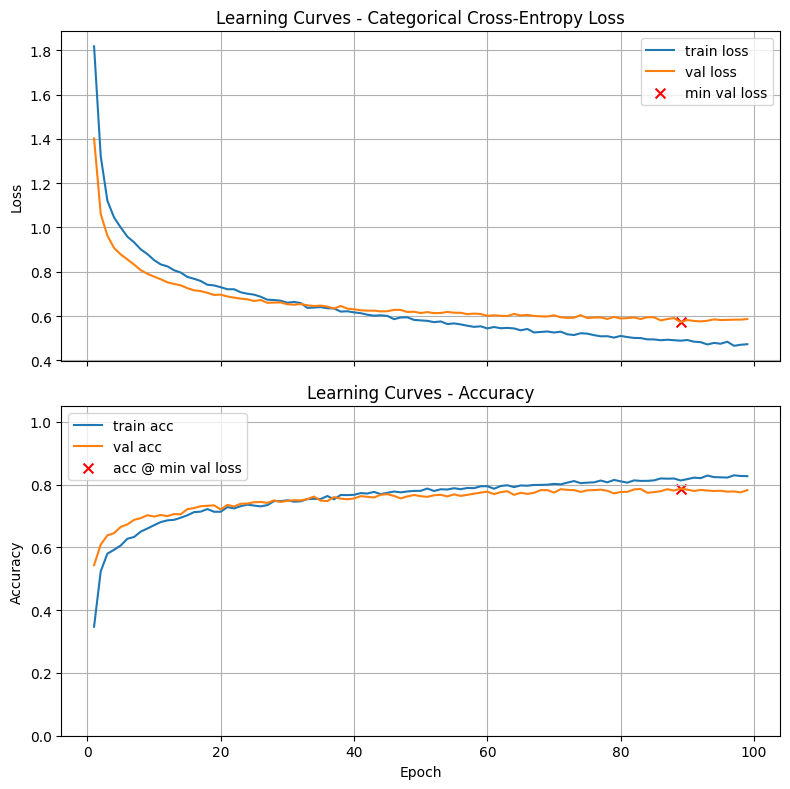

Final Training Loss:            0.4731
Final Training Accuracy:        0.8274
Final Validation Loss:          0.5867
Final Validation Accuracy:      0.7829
Minimum Validation Loss:        0.5728 (Epoch 89)
Validation Accuracy @ Min Loss: 0.7879

Test Loss: 0.6344
Test Accuracy: 0.7721

Validation-Test Gap (accuracy): 0.015714

Execution Time: 00:00:18

Learning Curves



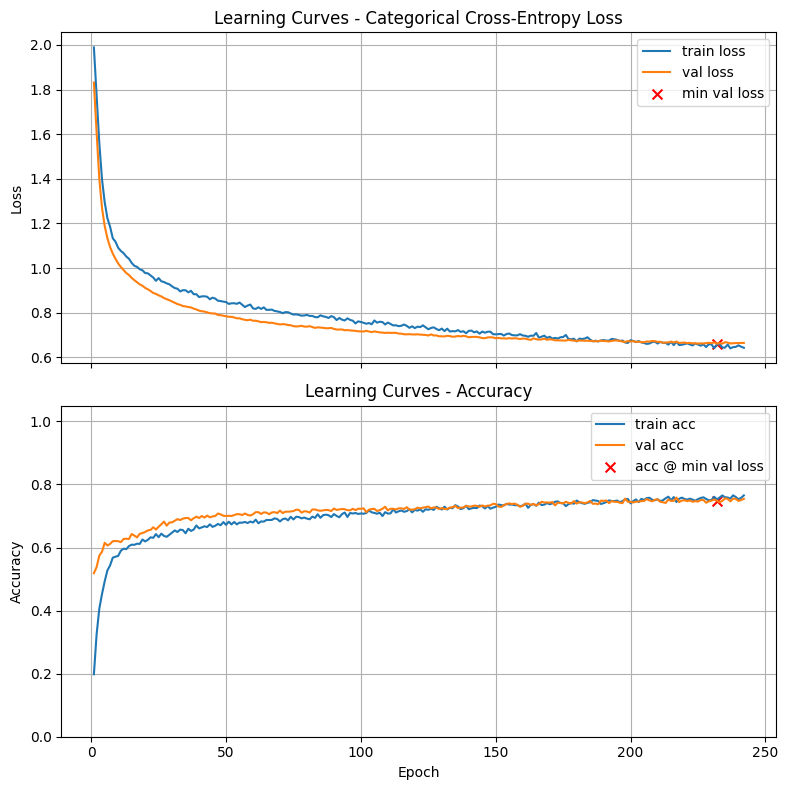

Final Training Loss:            0.6426
Final Training Accuracy:        0.7652
Final Validation Loss:          0.6642
Final Validation Accuracy:      0.7543
Minimum Validation Loss:        0.6608 (Epoch 232)
Validation Accuracy @ Min Loss: 0.7486

Test Loss: 0.6780
Test Accuracy: 0.7414

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:00:40

Learning Curves



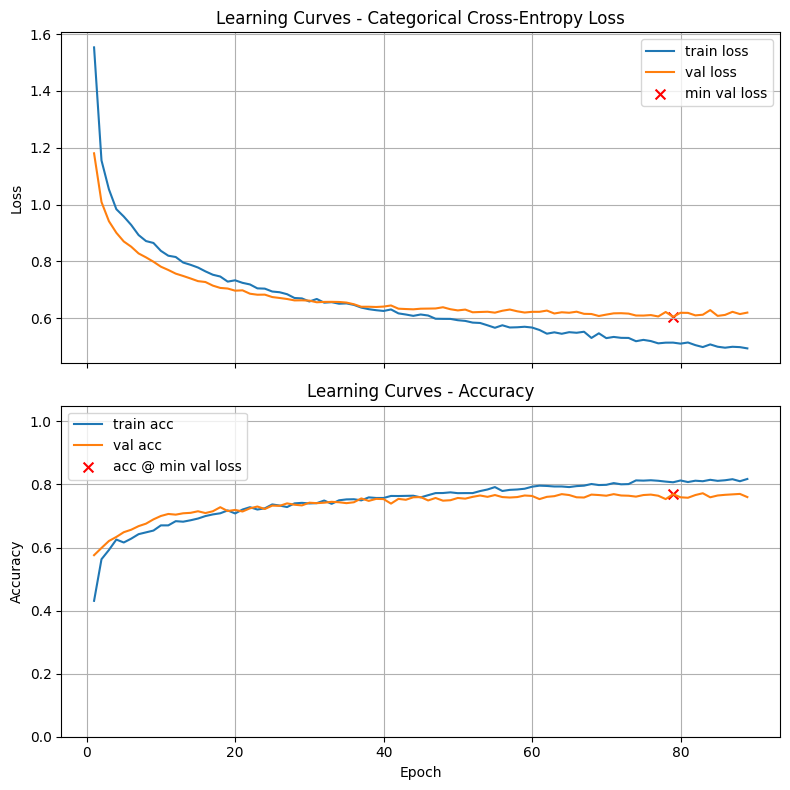

Final Training Loss:            0.4942
Final Training Accuracy:        0.8174
Final Validation Loss:          0.6202
Final Validation Accuracy:      0.7600
Minimum Validation Loss:        0.6054 (Epoch 79)
Validation Accuracy @ Min Loss: 0.7693

Test Loss: 0.6413
Test Accuracy: 0.7486

Validation-Test Gap (accuracy): 0.020714

Execution Time: 00:00:15


In [37]:
# Your code here. Add as many cells as you need. 
activation_list = ['relu', 'sigmoid', 'tanh']

for act_func in activation_list:
    model_baseline = build_model(X_train.shape[1],[(64,act_func,0.0,0.0), (32,act_func,0.001,0.3)], n_classes)
    train_and_test(model_baseline)


### Graded Questions

In [38]:
# Set a1a to the activation function which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 0             # Replace with integer 0 (relu), 1 (sigmoid), or 2 (tanh)

In [39]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a}') 


a1a = 0


In [40]:
# Set a1b to the validation accuracy found by this best activation function

a1b = 0.7879            # Replace 0.0 with your answer

In [41]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1b = {a1b:.4f}') 

a1b = 0.7879


### Problem Two: Finding the Right Learning Rate

In this problem, you will continue working with the **baseline model** and determine which learning rate produces the best performance. As before, the model you evaluate should be the one saved by **early stopping** — the epoch where validation loss is minimized.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function identified in Problem One**.

* Train and evaluate this model using each of the following learning rates:

  ```
      [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
  ```

* Identify which learning rate produces the **best validation accuracy** at the epoch of **minimum validation loss**, within a maximum of **500 epochs**.

* Answer the graded questions.


**Note: Smaller learning rates will generally take more epochs to reach the optimal point, so some of these will not engage early stopping, but run the full 500 epochs.**



0.001



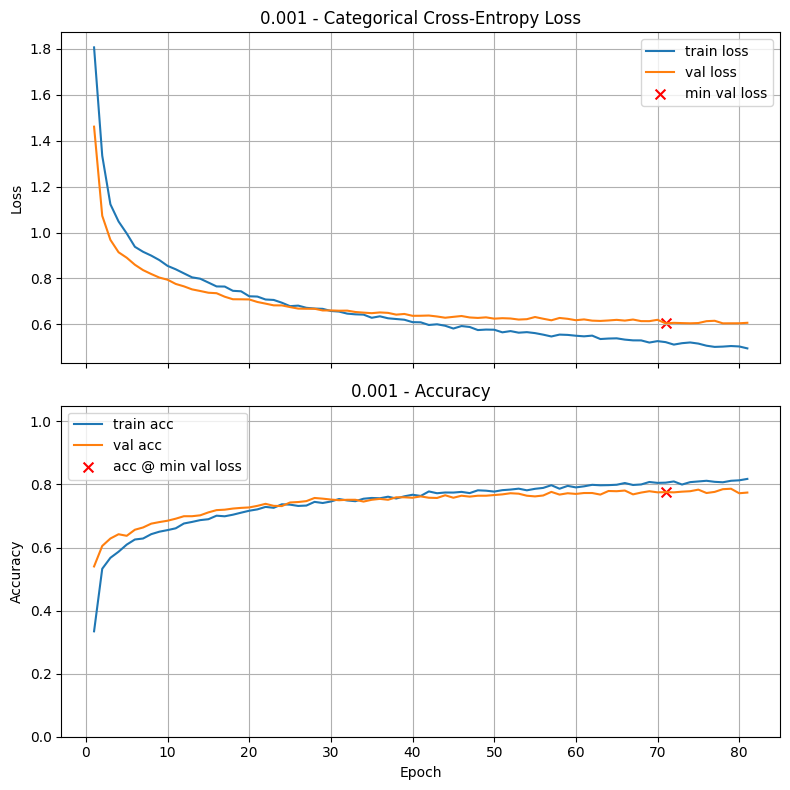

Final Training Loss:            0.4953
Final Training Accuracy:        0.8176
Final Validation Loss:          0.6067
Final Validation Accuracy:      0.7743
Minimum Validation Loss:        0.6044 (Epoch 71)
Validation Accuracy @ Min Loss: 0.7757

Test Loss: 0.6309
Test Accuracy: 0.7693

Validation-Test Gap (accuracy): 0.006429

Execution Time: 00:00:14

0.0005



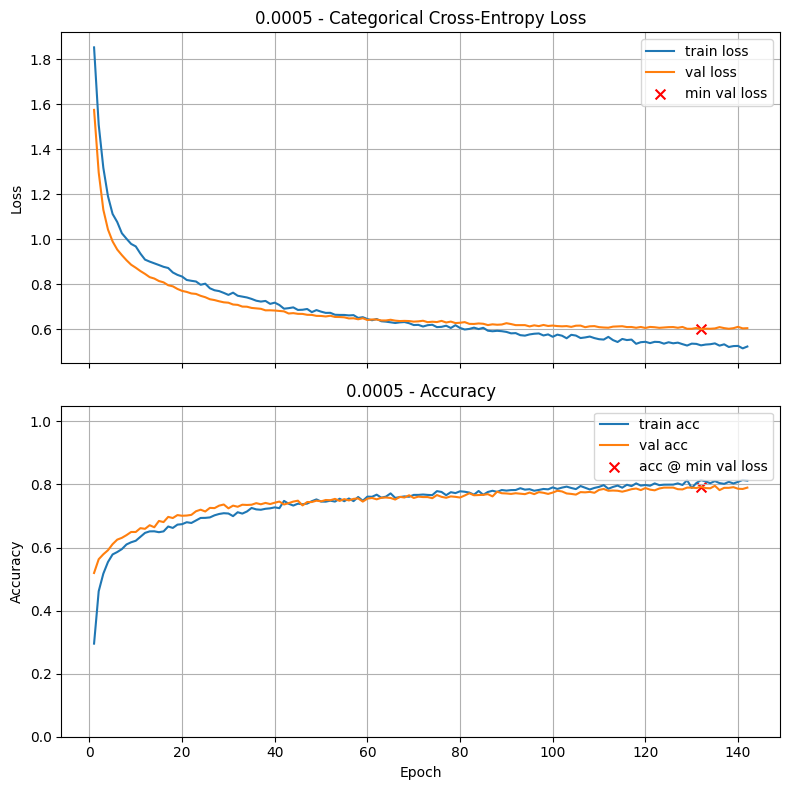

Final Training Loss:            0.5221
Final Training Accuracy:        0.8121
Final Validation Loss:          0.6037
Final Validation Accuracy:      0.7900
Minimum Validation Loss:        0.5997 (Epoch 132)
Validation Accuracy @ Min Loss: 0.7929

Test Loss: 0.6447
Test Accuracy: 0.7707

Validation-Test Gap (accuracy): 0.022143

Execution Time: 00:00:24

0.0001



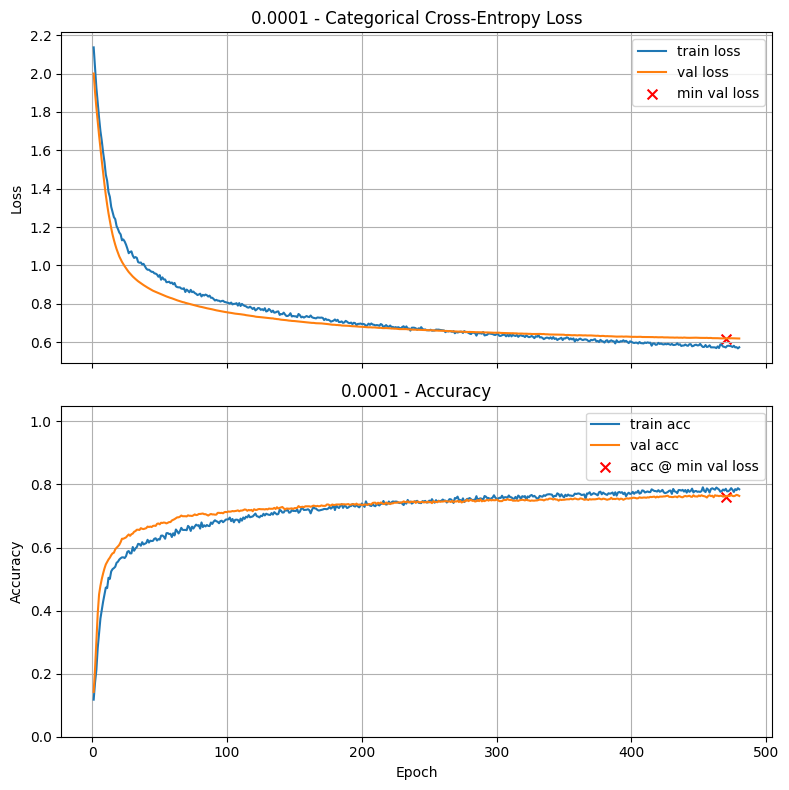

Final Training Loss:            0.5740
Final Training Accuracy:        0.7848
Final Validation Loss:          0.6196
Final Validation Accuracy:      0.7636
Minimum Validation Loss:        0.6196 (Epoch 470)
Validation Accuracy @ Min Loss: 0.7614

Test Loss: 0.6464
Test Accuracy: 0.7550

Validation-Test Gap (accuracy): 0.006429

Execution Time: 00:01:16

5e-05



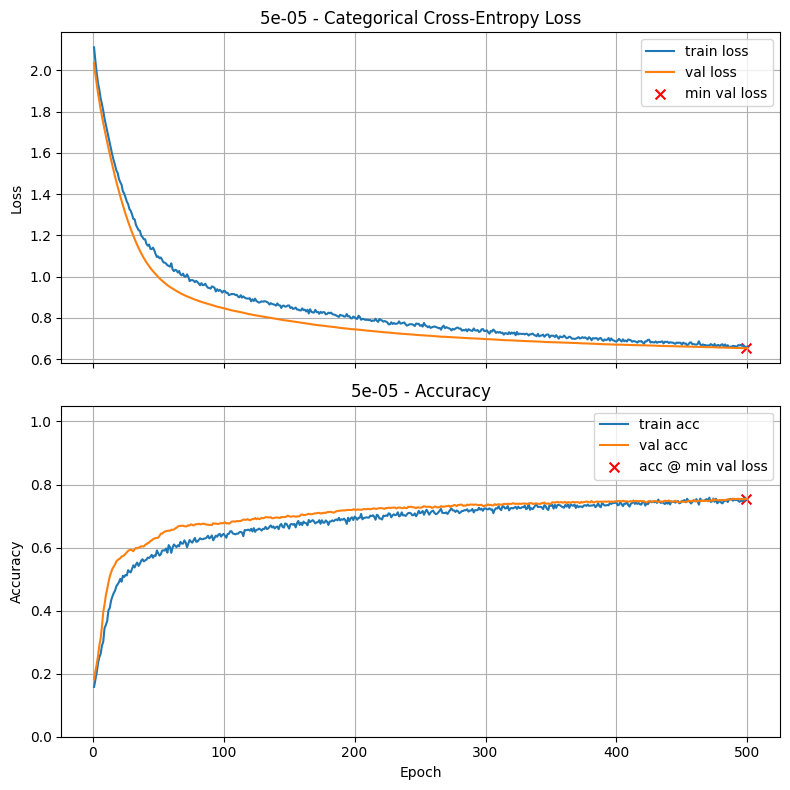

Final Training Loss:            0.6618
Final Training Accuracy:        0.7526
Final Validation Loss:          0.6533
Final Validation Accuracy:      0.7543
Minimum Validation Loss:        0.6532 (Epoch 499)
Validation Accuracy @ Min Loss: 0.7550

Test Loss: 0.6905
Test Accuracy: 0.7386

Validation-Test Gap (accuracy): 0.016429

Execution Time: 00:01:18

1e-05



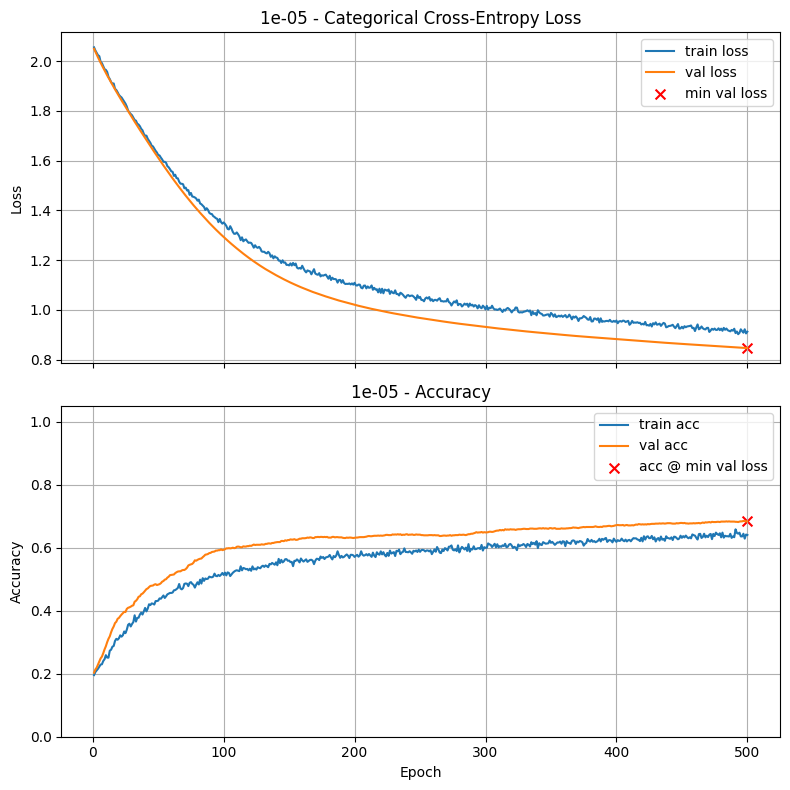

Final Training Loss:            0.9121
Final Training Accuracy:        0.6405
Final Validation Loss:          0.8461
Final Validation Accuracy:      0.6836
Minimum Validation Loss:        0.8461 (Epoch 500)
Validation Accuracy @ Min Loss: 0.6836

Test Loss: 0.8575
Test Accuracy: 0.6729

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:01:18


In [ ]:
# Your code here. Add as many cells as you need. 

lr_schedule = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]


for lr in lr_schedule:
    model_baseline = build_model(X_train.shape[1],[(64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes)
    train_and_test(model_baseline, lr_schedule = lr, title = lr)



#### Graded Questions

In [43]:
# Set a2a to the learning rate which provided the best validation accuracy at the epoch of minimum validation loss

a2a = 5e-4          # Replace 0.0 with your answer

In [44]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a:.6f}') 

a2a = 0.000500


In [45]:
# Set a2b to the validation accuracy found by this best learning rate

a2b = 0.7929             # Replace 0.0 with your answer

In [46]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7929


### Problem Three: Dropout

In this problem, you will explore how **dropout** can help prevent overfitting in neural networks. There are no absolute rules, but some useful hueristics are:

* Dropout typically works best in **later dense layers** (e.g., the second hidden layer of width 32) in the range **0.3–0.5**.
* If applied to **earlier layers** (e.g., the first hidden layer), dropout should be smaller, typically **0.0–0.2** (where 0.0 means no dropout).

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate dropout in the ranges suggested, using increments of **0.1**.
* Identify which dropout configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



0.3



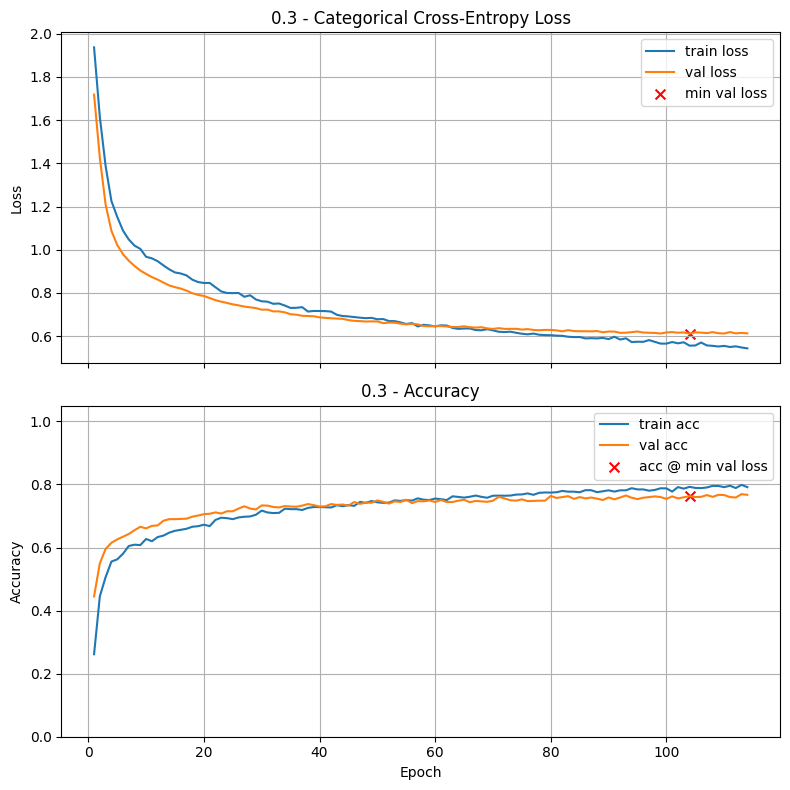

Final Training Loss:            0.5437
Final Training Accuracy:        0.7914
Final Validation Loss:          0.6133
Final Validation Accuracy:      0.7671
Minimum Validation Loss:        0.6119 (Epoch 104)
Validation Accuracy @ Min Loss: 0.7629

Test Loss: 0.6353
Test Accuracy: 0.7614

Validation-Test Gap (accuracy): 0.001429

Execution Time: 00:00:21

0.4



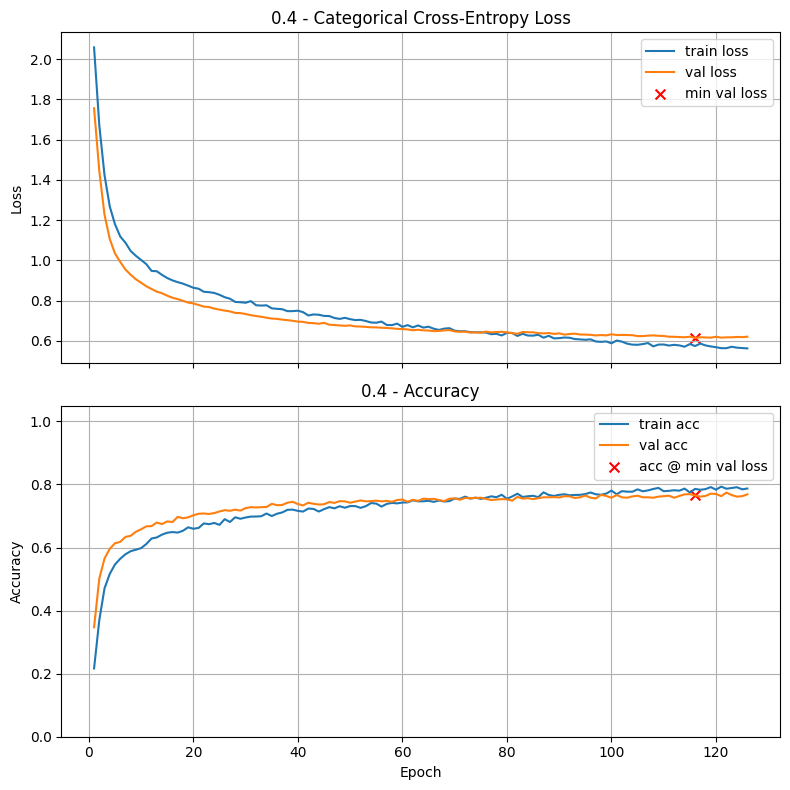

Final Training Loss:            0.5631
Final Training Accuracy:        0.7871
Final Validation Loss:          0.6210
Final Validation Accuracy:      0.7686
Minimum Validation Loss:        0.6152 (Epoch 116)
Validation Accuracy @ Min Loss: 0.7650

Test Loss: 0.6291
Test Accuracy: 0.7557

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:20

0.5



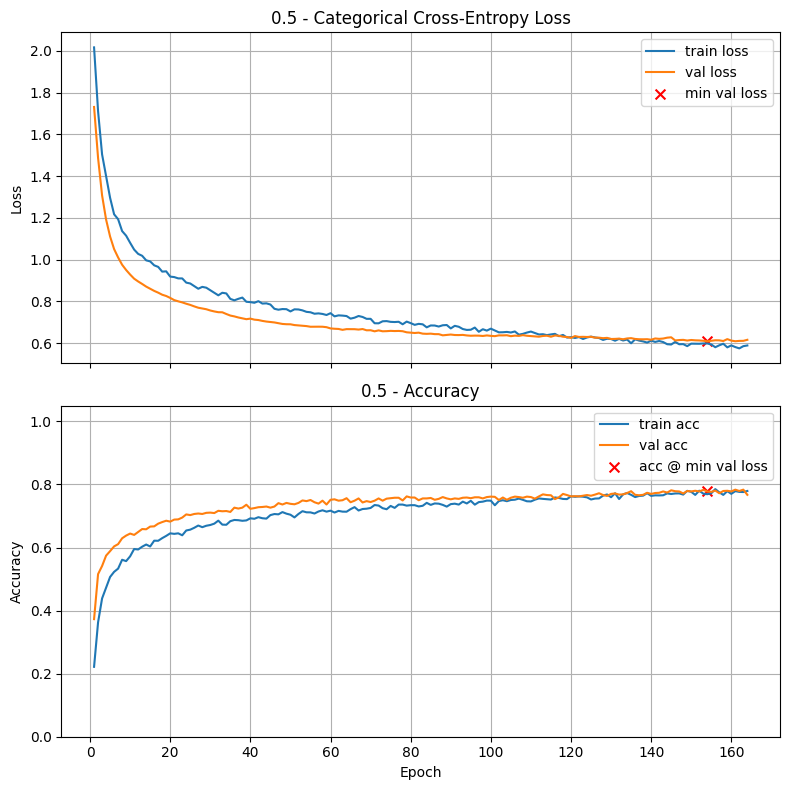

Final Training Loss:            0.5892
Final Training Accuracy:        0.7793
Final Validation Loss:          0.6162
Final Validation Accuracy:      0.7671
Minimum Validation Loss:        0.6091 (Epoch 154)
Validation Accuracy @ Min Loss: 0.7779

Test Loss: 0.6261
Test Accuracy: 0.7593

Validation-Test Gap (accuracy): 0.018571

Execution Time: 00:00:26

0.3



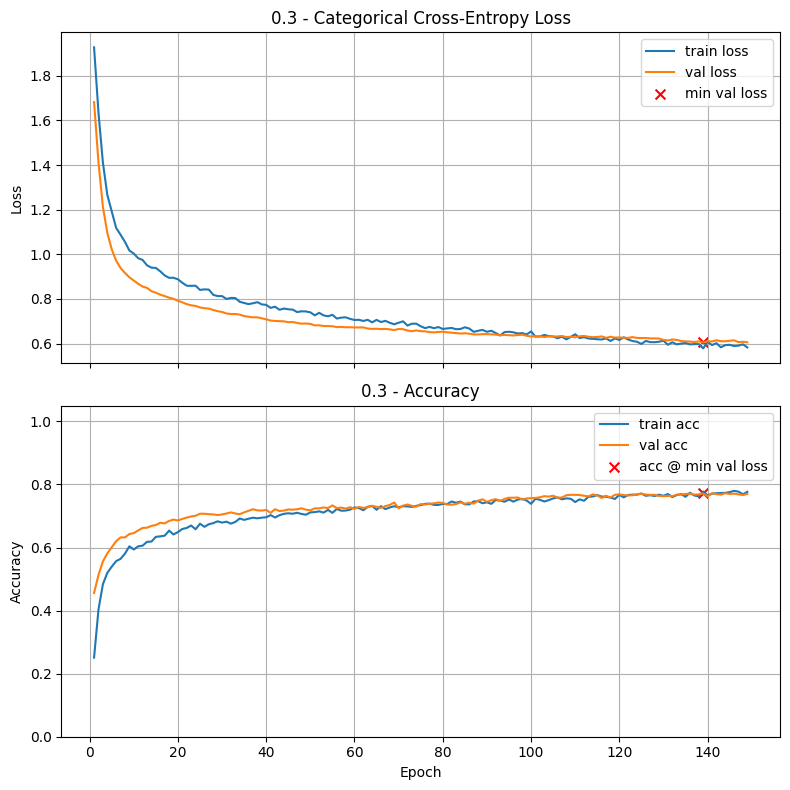

Final Training Loss:            0.5832
Final Training Accuracy:        0.7767
Final Validation Loss:          0.6061
Final Validation Accuracy:      0.7700
Minimum Validation Loss:        0.6053 (Epoch 139)
Validation Accuracy @ Min Loss: 0.7714

Test Loss: 0.6234
Test Accuracy: 0.7621

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:25

0.4



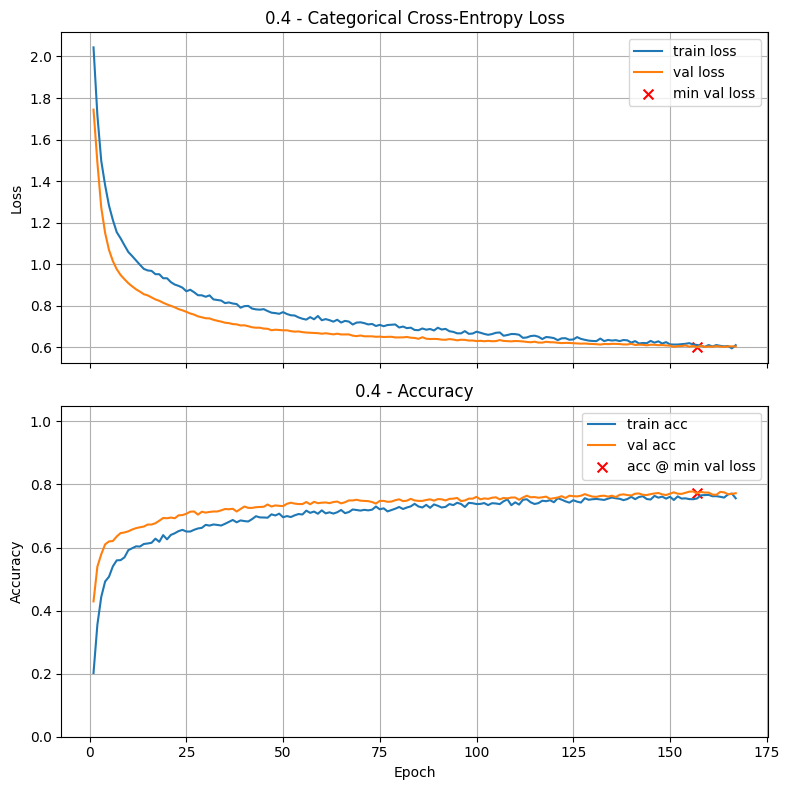

Final Training Loss:            0.6103
Final Training Accuracy:        0.7562
Final Validation Loss:          0.6036
Final Validation Accuracy:      0.7721
Minimum Validation Loss:        0.6010 (Epoch 157)
Validation Accuracy @ Min Loss: 0.7714

Test Loss: 0.6308
Test Accuracy: 0.7614

Validation-Test Gap (accuracy): 0.010000

Execution Time: 00:00:28

0.5



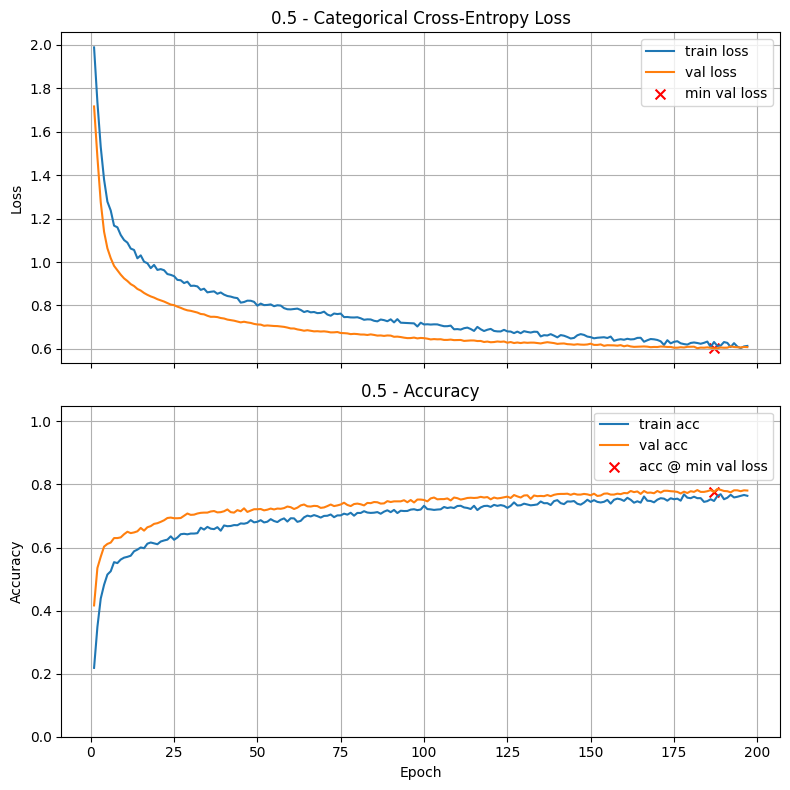

Final Training Loss:            0.6137
Final Training Accuracy:        0.7640
Final Validation Loss:          0.6083
Final Validation Accuracy:      0.7807
Minimum Validation Loss:        0.6024 (Epoch 187)
Validation Accuracy @ Min Loss: 0.7764

Test Loss: 0.6232
Test Accuracy: 0.7629

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:00:32

0.3



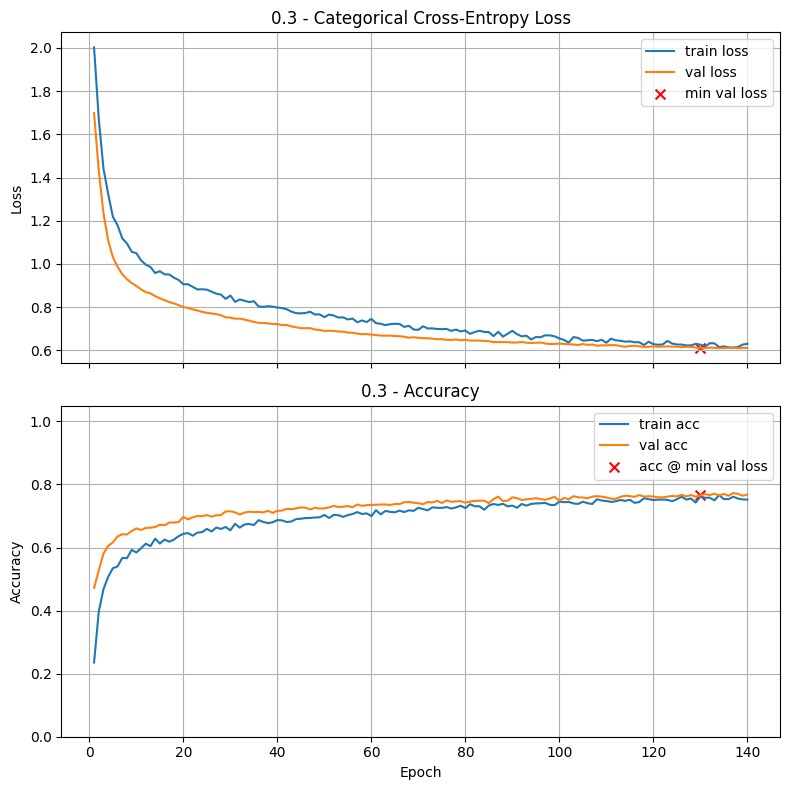

Final Training Loss:            0.6310
Final Training Accuracy:        0.7521
Final Validation Loss:          0.6119
Final Validation Accuracy:      0.7679
Minimum Validation Loss:        0.6097 (Epoch 130)
Validation Accuracy @ Min Loss: 0.7650

Test Loss: 0.6274
Test Accuracy: 0.7579

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:00:24

0.4



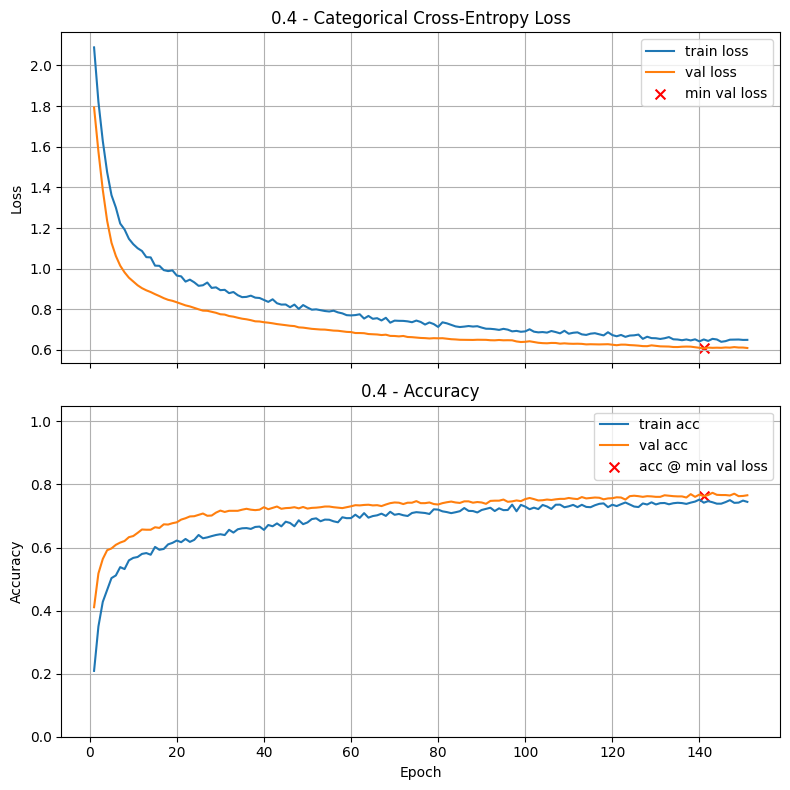

Final Training Loss:            0.6496
Final Training Accuracy:        0.7448
Final Validation Loss:          0.6096
Final Validation Accuracy:      0.7657
Minimum Validation Loss:        0.6077 (Epoch 141)
Validation Accuracy @ Min Loss: 0.7629

Test Loss: 0.6401
Test Accuracy: 0.7443

Validation-Test Gap (accuracy): 0.018571

Execution Time: 00:00:26

0.5



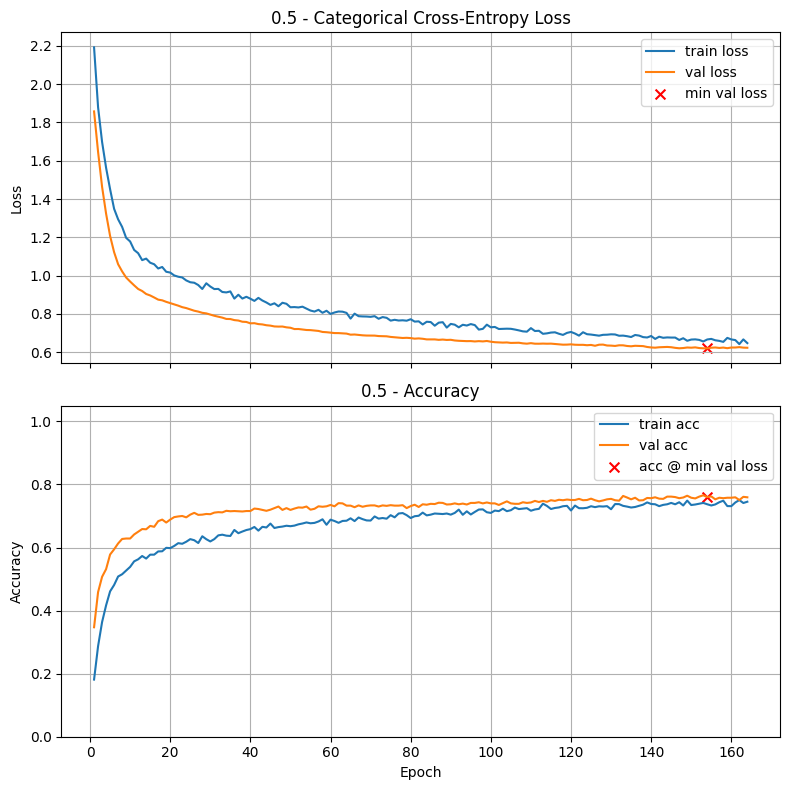

Final Training Loss:            0.6479
Final Training Accuracy:        0.7452
Final Validation Loss:          0.6236
Final Validation Accuracy:      0.7593
Minimum Validation Loss:        0.6204 (Epoch 154)
Validation Accuracy @ Min Loss: 0.7600

Test Loss: 0.6553
Test Accuracy: 0.7507

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:28


In [49]:
    # Your code here. Add as many cells as you need. 
for num in np.arange(0.0,0.3,0.1):
    for value in np.arange(0.3, 0.6, 0.1):
        model_baseline = build_model(
            X_train.shape[1],
            [(64, 'relu', 0.0, num), (32, 'relu', 0.001, value)],
            n_classes
        )
        train_and_test(model_baseline, lr_schedule=5e-4, title=value)



In [50]:
# Set a3a to the pair (dropout_rate_64,dropout_rate_32) of dropout rates for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a3a = (0.0,0.5)             # Replace (0.0,0.0) with your answer

In [51]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a}') 

a3a = (0.0, 0.5)


In [52]:
# Set a3b to the validation accuracy found by this best pair of dropout rates

a3b = 0.7779             # Replace 0.0 with your answer

In [53]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.7779


### Problem Four: L2 Regularization

In this problem, you will explore how **L2 regularization** (also called *weight decay*) can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Start simple by using the **same λ in both hidden layers**, with values:

  ```
      1e-4, 1e-3, 1e-2
  ```

* If validation results suggest underfitting in the first layer or persistent overfitting in the later one, then try adjusting per layer, for example:

  * First hidden layer: λ = 1e-4
  * Second hidden layer: λ = 1e-3

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**, but **without dropout**.
* Investigate at least the four cases suggested (three with the same λ and one with different λ values). You may also consider additional combinations.
* Identify which configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



0.0001



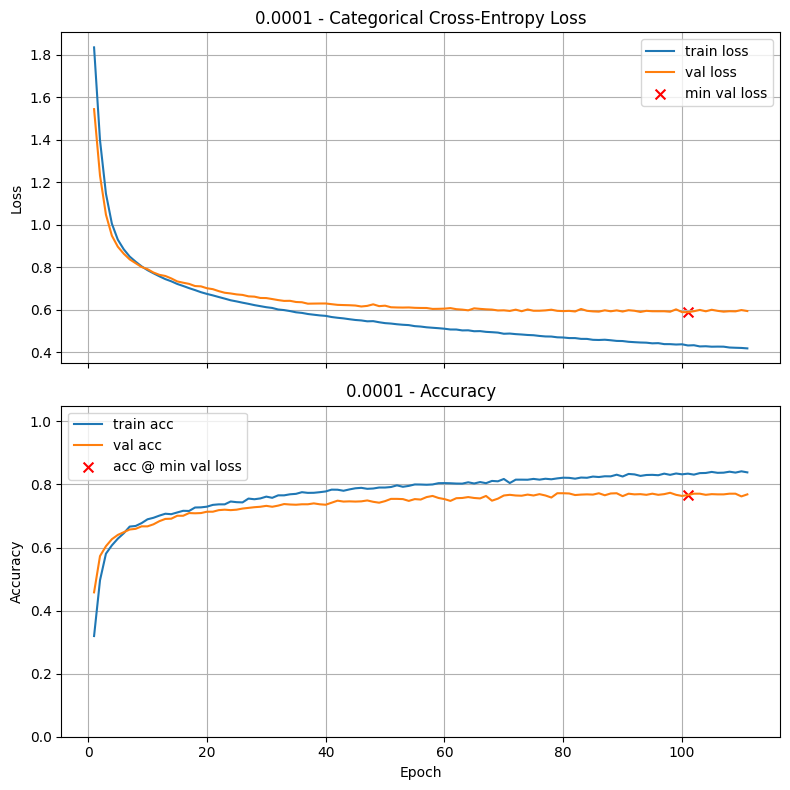

Final Training Loss:            0.4182
Final Training Accuracy:        0.8383
Final Validation Loss:          0.5937
Final Validation Accuracy:      0.7686
Minimum Validation Loss:        0.5885 (Epoch 101)
Validation Accuracy @ Min Loss: 0.7664

Test Loss: 0.6274
Test Accuracy: 0.7636

Validation-Test Gap (accuracy): 0.002857

Execution Time: 00:00:18

0.001



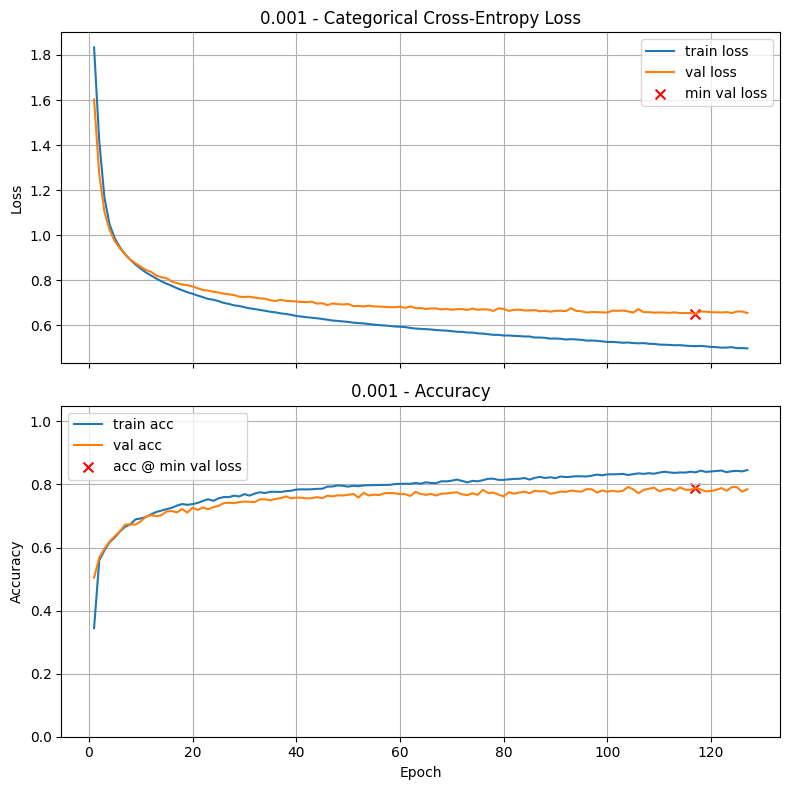

Final Training Loss:            0.4984
Final Training Accuracy:        0.8455
Final Validation Loss:          0.6554
Final Validation Accuracy:      0.7850
Minimum Validation Loss:        0.6516 (Epoch 117)
Validation Accuracy @ Min Loss: 0.7886

Test Loss: 0.6749
Test Accuracy: 0.7650

Validation-Test Gap (accuracy): 0.023571

Execution Time: 00:00:21

0.01



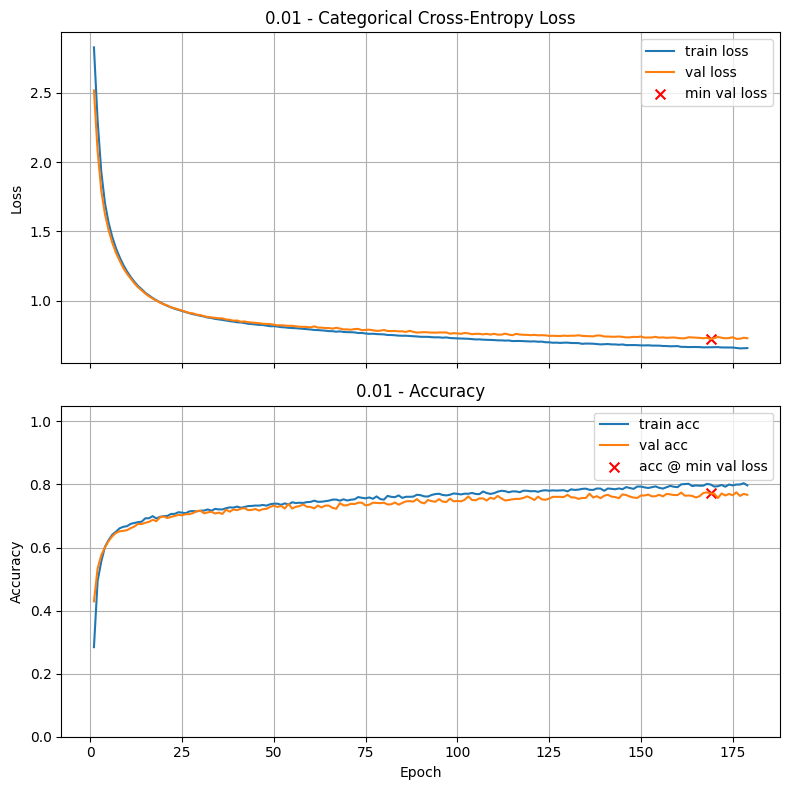

Final Training Loss:            0.6586
Final Training Accuracy:        0.7971
Final Validation Loss:          0.7298
Final Validation Accuracy:      0.7671
Minimum Validation Loss:        0.7235 (Epoch 169)
Validation Accuracy @ Min Loss: 0.7714

Test Loss: 0.7400
Test Accuracy: 0.7586

Validation-Test Gap (accuracy): 0.012857

Execution Time: 00:00:30


In [55]:
# Your code here. Add as many cells as you need. 

for value in [1e-4,1e-3,1e-2]:
    model_baseline = build_model(
                X_train.shape[1],
                [(64, 'relu', value, 0.0), (32, 'relu', value, 0.0)],
                n_classes
            )
    train_and_test(model_baseline, lr_schedule=5e-4, title=value)


0.01



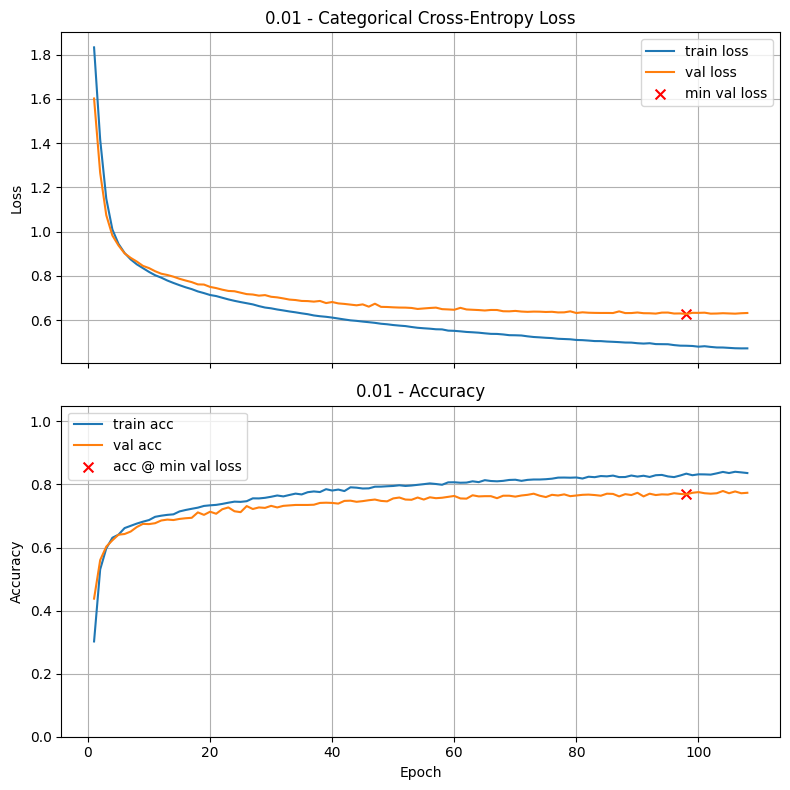

Final Training Loss:            0.4729
Final Training Accuracy:        0.8362
Final Validation Loss:          0.6327
Final Validation Accuracy:      0.7736
Minimum Validation Loss:        0.6282 (Epoch 98)
Validation Accuracy @ Min Loss: 0.7686

Test Loss: 0.6670
Test Accuracy: 0.7614

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:00:18


In [56]:
model_baseline = build_model(
                X_train.shape[1],
                [(64, 'relu', 1e-4, 0.0), (32, 'relu', 1e-3, 0.0)],
                n_classes
            )
train_and_test(model_baseline, lr_schedule=5e-4, title=value)

In [57]:
# Set a4a to the pair (L2_lambda_64,L2_lambda_32) of the L2 lambdas for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a4a = (1e-3,1e-3)             # Replace (0.0,0.0) with your answer

In [58]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a}') 

a4a = (0.001, 0.001)


In [59]:
# Set a4b to the validation accuracy found by this best pair of lambdas

a4b = 0.7886             # Replace 0.0 with your answer

In [60]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.7886


### Problem Five: Combining Dropout with L2 Regularization

In this problem, you will explore how **dropout** and **L2 regularization** can work together to prevent overfitting. These two methods complement each other, but must be balanced carefully. A useful rule of thumb is:

* If dropout is **high**, use a **smaller λ**.
* If dropout is **low**, you can afford a **larger λ**.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate combinations of dropout and L2:

  * First, use the **dropout rate you identified in Problem Three** as a baseline.
  * Then, add L2 to both hidden layers with values:

    ```
        1e-4, 1e-3, 1e-2
    ```

    while keeping dropout fixed.
  * Finally, try **reducing dropout slightly** when L2 is added to see if performance improves.
  * [Optional] You may wish to investigate other combinations not covered here; for example, promising but not optimal choices of dropout rates may provide overall better performance when combines with L2 Regulari 
* Identify which combination produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.




dropout_0.0_0.5_l2_0.0001



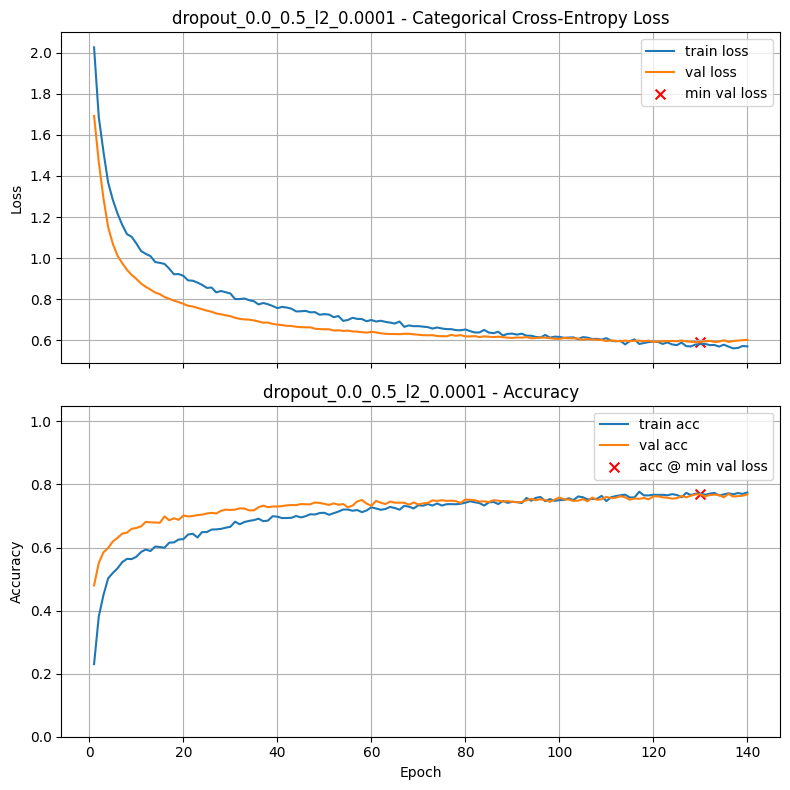

Final Training Loss:            0.5712
Final Training Accuracy:        0.7745
Final Validation Loss:          0.6031
Final Validation Accuracy:      0.7686
Minimum Validation Loss:        0.5918 (Epoch 130)
Validation Accuracy @ Min Loss: 0.7686

Test Loss: 0.6313
Test Accuracy: 0.7521

Validation-Test Gap (accuracy): 0.016429

Execution Time: 00:00:26

dropout_0.0_0.5_l2_0.001



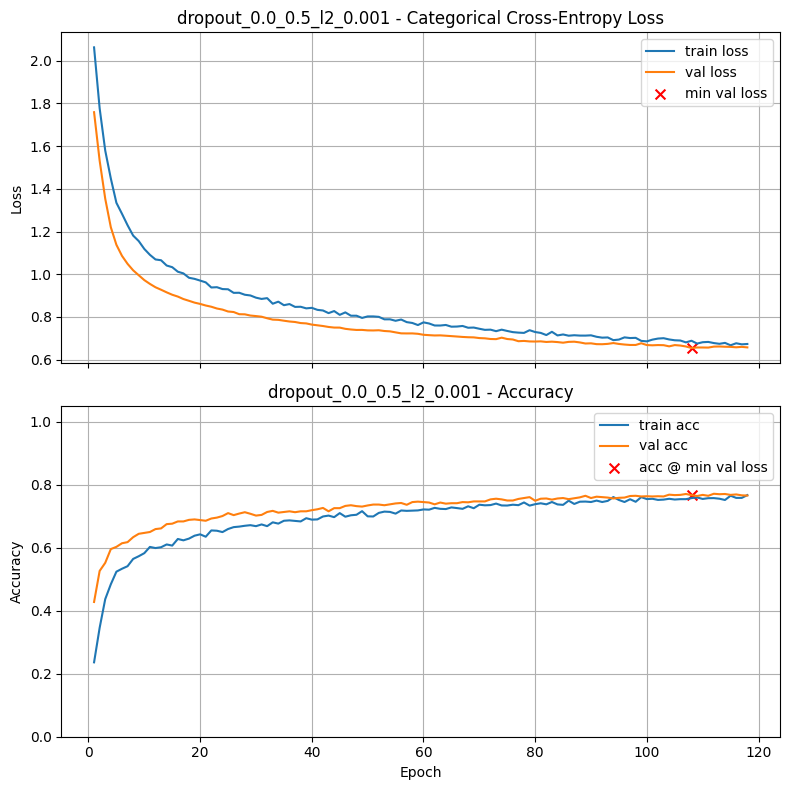

Final Training Loss:            0.6735
Final Training Accuracy:        0.7671
Final Validation Loss:          0.6575
Final Validation Accuracy:      0.7657
Minimum Validation Loss:        0.6547 (Epoch 108)
Validation Accuracy @ Min Loss: 0.7671

Test Loss: 0.6844
Test Accuracy: 0.7507

Validation-Test Gap (accuracy): 0.016429

Execution Time: 00:00:20

dropout_0.0_0.5_l2_0.01



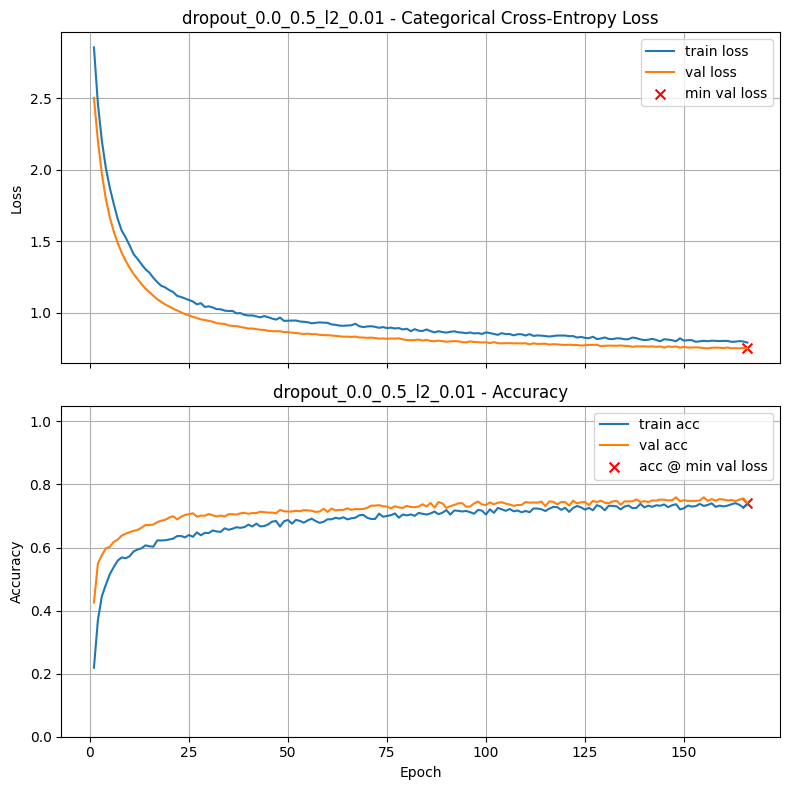

Final Training Loss:            0.7904
Final Training Accuracy:        0.7369
Final Validation Loss:          0.7501
Final Validation Accuracy:      0.7421
Minimum Validation Loss:        0.7501 (Epoch 166)
Validation Accuracy @ Min Loss: 0.7421

Test Loss: 0.7710
Test Accuracy: 0.7386

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:28

dropout_-0.05_0.45_l2_0.0001



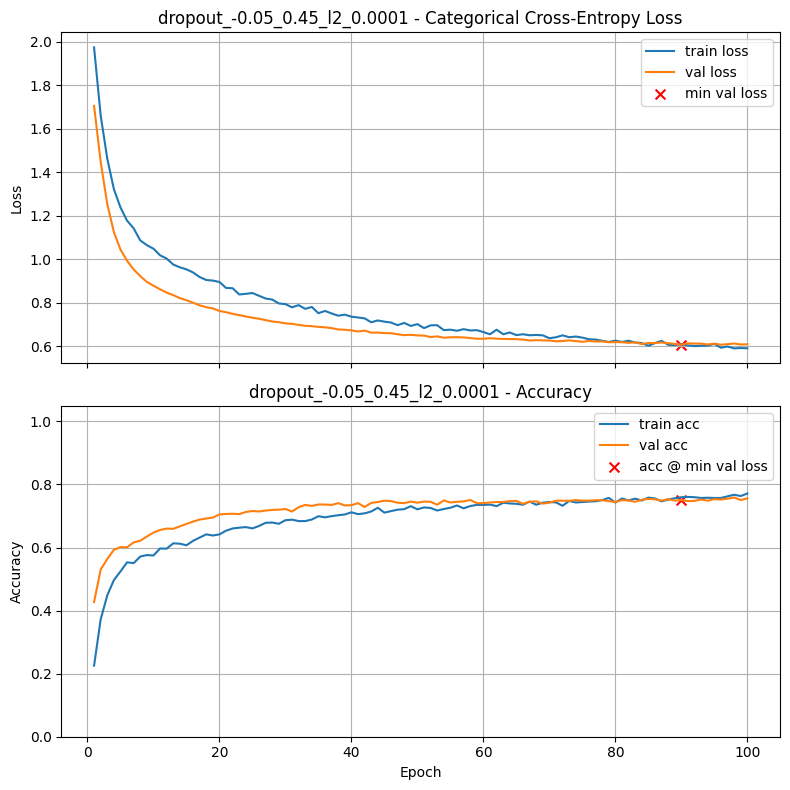

Final Training Loss:            0.5916
Final Training Accuracy:        0.7712
Final Validation Loss:          0.6101
Final Validation Accuracy:      0.7557
Minimum Validation Loss:        0.6080 (Epoch 90)
Validation Accuracy @ Min Loss: 0.7507

Test Loss: 0.6428
Test Accuracy: 0.7529

Validation-Test Gap (accuracy): 0.002143

Execution Time: 00:00:18

dropout_-0.05_0.45_l2_0.001



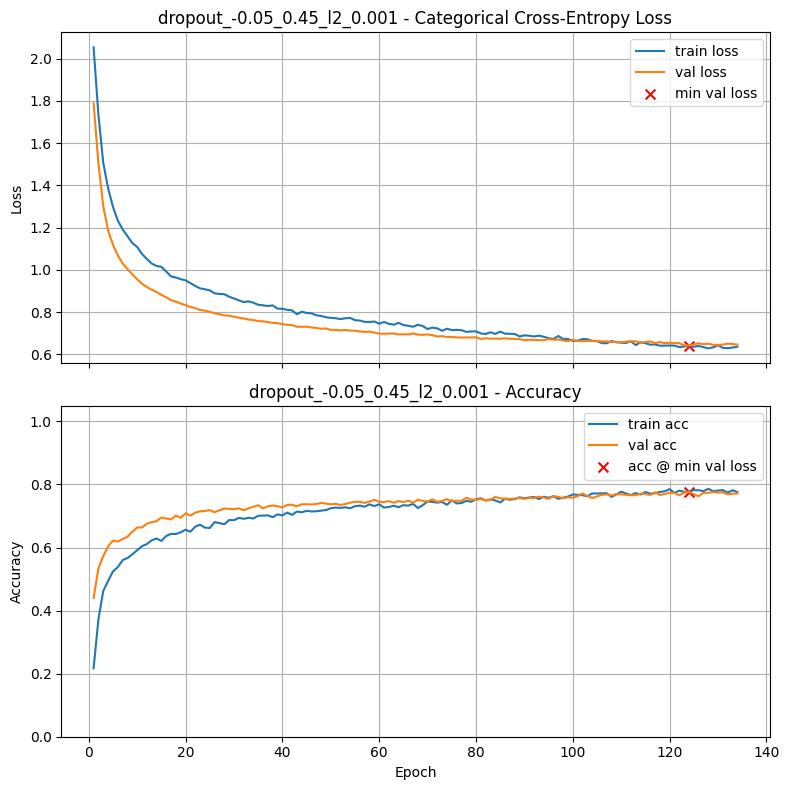

Final Training Loss:            0.6360
Final Training Accuracy:        0.7755
Final Validation Loss:          0.6462
Final Validation Accuracy:      0.7714
Minimum Validation Loss:        0.6412 (Epoch 124)
Validation Accuracy @ Min Loss: 0.7764

Test Loss: 0.6821
Test Accuracy: 0.7529

Validation-Test Gap (accuracy): 0.023571

Execution Time: 00:00:23

dropout_-0.05_0.45_l2_0.01



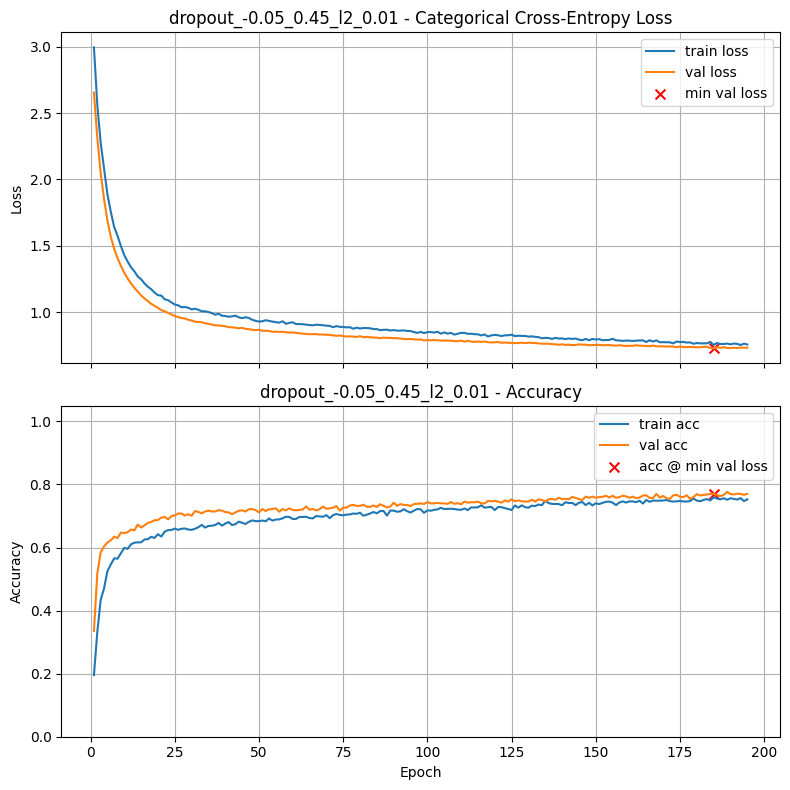

Final Training Loss:            0.7571
Final Training Accuracy:        0.7526
Final Validation Loss:          0.7328
Final Validation Accuracy:      0.7700
Minimum Validation Loss:        0.7278 (Epoch 185)
Validation Accuracy @ Min Loss: 0.7700

Test Loss: 0.7559
Test Accuracy: 0.7371

Validation-Test Gap (accuracy): 0.032857

Execution Time: 00:00:32


In [ ]:
# Your code here. Add as many cells as you need.
d1_dropout = 0.0 
d2_dropout = 0.5  

l2_values = [1e-4, 1e-3, 1e-2]

for l2 in l2_values:
    model = build_model(
        X_train.shape[1],
        [(64, 'relu', l2, d1_dropout), (32, 'relu', l2, d2_dropout)],
        n_classes
    )
    train_and_test(model, lr_schedule=5e-4, title=f'dropout_{d1_dropout}_{d2_dropout}_l2_{l2}')

for l2 in l2_values:
    model = build_model(
        X_train.shape[1],
        [(64, 'relu', l2, d1_dropout), (32, 'relu', l2, d2_dropout - 0.05)],
        n_classes
    )
    train_and_test(model, lr_schedule=5e-4, title=f'dropout_{d1_dropout}_{d2_dropout-0.05}_l2_{l2}')



In [62]:
# Set a5 to the validation accuracy found by this best combination of dropout and L2 regularization

a5 = 0.7700             # Replace 0.0 with your answer

In [63]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5 = {a5:.4f}') 

a5 = 0.7700


### Problem Six: Build and Train Your Best Model

In this final problem, you will design and train your **best-performing model** using the techniques explored in the previous problems. You may make your own choices for:

* **Model architecture** (number of layers, widths, etc.)
* **Learning rate**
* **Batch size** (a new hyperparameter not varied in earlier problems)
* **Dropout rates** in both layers
* **L2 λ values** in both layers
* **[Optional but strongly suggested]:** Learning rate scheduling, using either **Exponential Decay** or **Cosine Decay**.

  * For Exponential Decay, typical decay rates are **0.90–0.999**, with **0.95** often a good starting point.

**Steps to follow:**

* Build and train the model according to your design choices.
* Use early stopping as before to evaluate performance at the epoch of **minimum validation loss**.
* Answer the graded question.



Best_Model



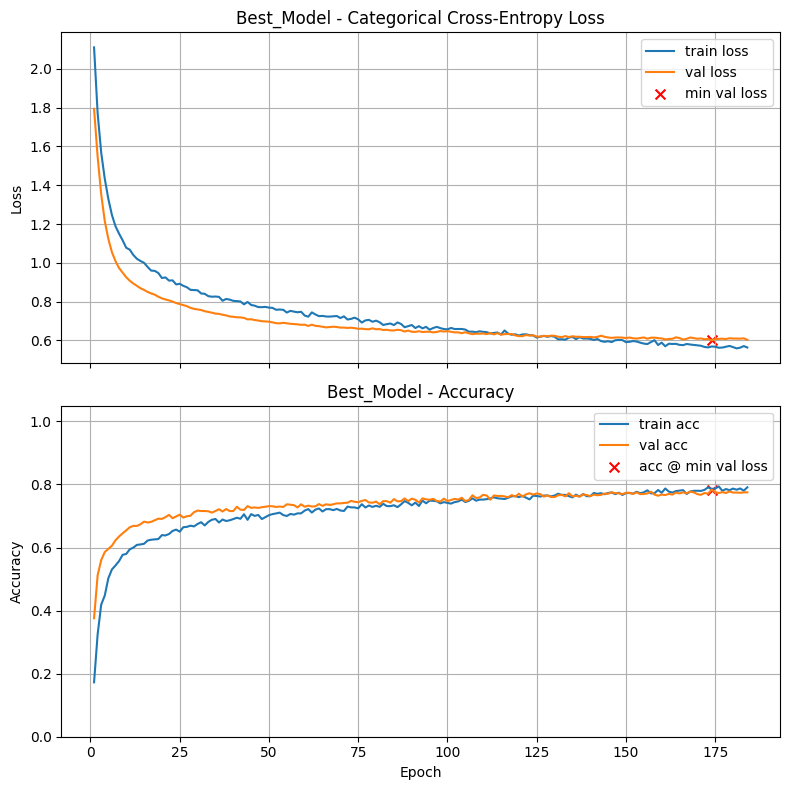

Final Training Loss:            0.5634
Final Training Accuracy:        0.7910
Final Validation Loss:          0.6029
Final Validation Accuracy:      0.7750
Minimum Validation Loss:        0.6003 (Epoch 174)
Validation Accuracy @ Min Loss: 0.7836

Test Loss: 0.6119
Test Accuracy: 0.7714

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:30


In [ ]:
model_baseline = build_model(X_train.shape[1],[(64,'relu',0.0,0.0), (32,'relu',0.001,0.5)], n_classes)
train_and_test(model_baseline, lr_schedule = 5e-4, title = 'Best_Model')

In [96]:
# Set a6 to the validation accuracy found by this best model

a6 = 0.7836             # Replace 0.0 with your answer

In [97]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a6 = {a6:.4f}') 

a6 = 0.7836


### Optional: Print out your results of all experiments

In [98]:
print_results()

0.0005                                  	0.7929
0.001                                   	0.7886
1e-05                                   	0.7850
Best_Model                              	0.7836
dropout_-0.05_0.45_l2_0.001             	0.7764
Best Model Training                     	0.7729
dropout_-0.05_0.45_l2_0.01              	0.7700
Learning Curves                         	0.7693
0.01                                    	0.7686
dropout_0.0_0.5_l2_0.0001               	0.7686
dropout_0.0_0.5_l2_0.001                	0.7671
0.0001                                  	0.7664
0.3                                     	0.7650
0.4                                     	0.7629
0.5                                     	0.7600
5e-05                                   	0.7550
dropout_-0.05_0.45_l2_0.0001            	0.7507
dropout_0.0_0.5_l2_0.01                 	0.7421


## Reflection Questions (ungraded)

1. Activation Functions:

    - Why do you think one activation function worked better than the others for this task?
    
    - How might this choice differ for deeper or wider networks?

2. Learning Rate:

    - Would a much smaller learning rate (with many more epochs) likely produce better accuracy?
    
    - When is it worth training longer with a smaller step size, and when is it unnecessary?

3. Dropout vs. L2:

    - Which form of regularization — dropout or L2 — gave better results in your experiments?
    
    - Why might one method be more effective in this setting?

4. Combining Dropout and L2:

    - Why might the combination of dropout and L2 sometimes perform worse than using one method alone?
    
    - What does this tell you about the balance between bias and variance in regularization?

5. Best Model:

    - When you designed your best model, what trade-offs did you notice between model complexity, training stability, and generalization?
    
    - Did learning rate scheduling (if you tried it) improve results? Why might it help?